## Baseline Model

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

#define  basis functions
def make_basis(x):
    # the components are 1,x, cos(2 \pi x), sin(2 \pi x)...
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 

#  periodic basis starts at column:
col_per = 2

#baseline model
def run_model(x,y,plot=False):    
    H = make_basis(x.reshape(-1,1))
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    H_np = H[:,0:col_per]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    all_prediction = np.dot(H,posterior['weights'].T).T
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    if plot==True:
        plt.figure()
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)
    Gradients = []
    for i in range(non_periodic_prediction.shape[0]):
        Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
        
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print("probability that the function is increasing=", posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0

    
#this is the inpu
x = np.linspace(0,1,100)    

We test the model in a toy example. If we remove the seasonality component, then the following time-series is increasing.

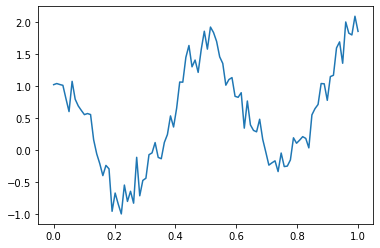

In [2]:

y =  x + np.cos(4*np.pi*x) + np.random.randn(len(x))*0.2
plt.plot(x,y)

Average Loss = 96.464: 100%|██████████| 60000/60000 [00:30<00:00, 1966.37it/s]
Finished [100%]: Average Loss = 96.463


probability that the function is increasing= 1.0


1

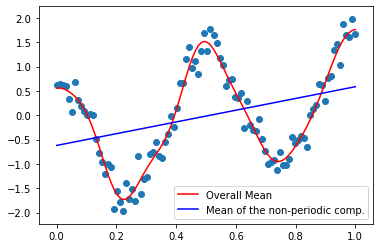

In [3]:
run_model(x,y,plot=True)

It works well in this case :)

In the following example, the  time-series is not increasing and it does not have any seasonality component.

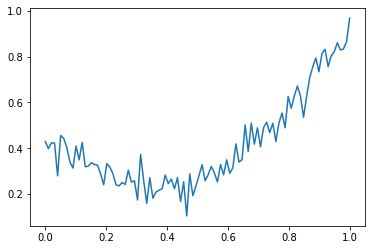

In [4]:
#toy example
y =  x/2-2*np.exp(-(x-0.5)**2) + 2 + np.random.randn(len(x))*0.05
plt.plot(x,y)

Average Loss = 104.41: 100%|██████████| 60000/60000 [00:44<00:00, 1358.92it/s]
Finished [100%]: Average Loss = 104.42


probability that the function is increasing= 1.0


1

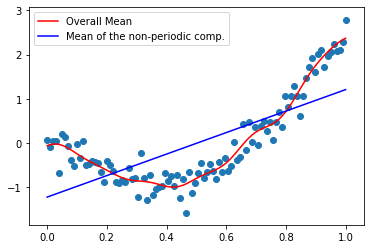

In [5]:
run_model(x,y, plot=True)

It doesn't work well, the correct answer should be not-increasing. The problem is that the cos/sin base can also fit any non-linear function in [0,1] :(.

## We run it on the test set

In [7]:
x = np.linspace(0,1,100)
train_df = pd.read_csv("Dataset/train.csv")
test_df = pd.read_csv("Dataset/test.csv")


Decision = pd.DataFrame(columns=['Id','Category'])
for r in range(train_df.shape[0]):
    id_row = test_df.iloc[r,0]
    y = test_df.iloc[r,1:].values
    decision = run_model(x,y)
    Decision = Decision.append({'Id': int(id_row), 'Category': int(decision)}, ignore_index=True) 
    print(Decision)
    Decision.to_csv("Decision_baseline.csv",  index=False)

Average Loss = 127.89: 100%|██████████| 60000/60000 [00:47<00:00, 1272.95it/s]
Finished [100%]: Average Loss = 127.89


probability that the function is increasing= 1.0
  Id Category
0  0        1


Average Loss = 201.68: 100%|██████████| 60000/60000 [00:34<00:00, 1747.89it/s]
Finished [100%]: Average Loss = 201.68


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1


Average Loss = 211.99: 100%|██████████| 60000/60000 [00:30<00:00, 1985.37it/s]
Finished [100%]: Average Loss = 212


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1


Average Loss = 216.69: 100%|██████████| 60000/60000 [00:33<00:00, 1771.93it/s]
Finished [100%]: Average Loss = 216.69


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1


Average Loss = 116.56:  98%|█████████▊| 59070/60000 [00:36<00:00, 1614.74it/s]
Interrupted at 59,177 [98%]: Average Loss = 150.36


probability that the function is increasing= 1.0
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1
4  4        1


Average Loss = 286.3:   5%|▍         | 2846/60000 [00:02<00:43, 1303.26it/s] 
Interrupted at 2,940 [4%]: Average Loss = 304.4


probability that the function is increasing= 0.67
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1
4  4        1
5  5        0


Average Loss = 233.59:  12%|█▏        | 7310/60000 [00:04<00:33, 1575.90it/s]
Interrupted at 7,350 [12%]: Average Loss = 274.35


probability that the function is increasing= 0.77
  Id Category
0  0        1
1  1        1
2  2        1
3  3        1
4  4        1
5  5        0
6  6        0


KeyboardInterrupt: 

## Ideas to improve baseline

1. Adding another non-linear basis function components (e.g., $tanh(w0+w1x)$) and seeing if you can better split the seasonal and non-seasonal component.
2. In the second example, the sin/cos basis function fits the nonlinear function, but it is clear that the obtained mean function is non-periodic. By definition a function is periodic in the interval [0,1] if you see at least one full cycle (e.g. $cos(\pi x)$ is not peridic in [0,1] but $cos(2 \pi x)$ is). So you could try to verify if the function is periodic or not. In case it is periodic you can use "non_periodic_prediction" for checking if the function is increasing or not. Instead, if the function is not periodic that you could use  "all_prediction" for checking if the function is increasing or not. How can you test if a function is periodic or not given your basis functions in H ?
3. The baseline model computes the derivative of the non-seasonal component and checks if the derivative is non-negative for all $x\in[0,1]$ as a way to assess if sales are increasing. Could an analytical derivative work better in the above case?
4. You could try to use GPs
5. Is the decision criterion "posterior_probability_deriviative_is_positive>0.95" the best way to make decisions? Maybe you would do better if you take into account the way weighted accuracy is defined for this competition.